# Grundlagen der KI Projekt Aufgabe
### Housing Price Prediction
*Nantke Janssen, Johannes Mayer und Kiuas*

Das folgende Projekt untergliedert sich in drei Abschnitte:  
  

      1. Preprocessing  
      2. Modeling  
      3. Analyse

Als erstes müssen jedoch die benötigten Bibliotheken installiert werden.

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Und die csv Datei mit den Daten geladen werden.

In [268]:
data=pd.read_csv('Housing.csv')

data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## 1. Preprocessing

Wir nutzen einen LabelEncoder, um kategoriale Daten in numerische Werte umzuwandeln ohne dabei neue Spalten zu erzeugen.

In [269]:
encoder = LabelEncoder()

encoding = [ 'prefarea', 'airconditioning', 
                'hotwaterheating', 'basement', 'guestroom', 'mainroad']


furnishingstatus_mapping = {'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0}
data['furnishingstatus'] = data['furnishingstatus'].map(furnishingstatus_mapping)

for column in encoding:
    data[column] = encoder.fit_transform(data[column])

data.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2


Wir prüfen, ob es fehlende Werte im Datensatz gibt.

In [270]:
data.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In diesem Datensatz gibt es keine fehlenden Werte, somit müssen diese Datenlücken nicht gefüllt werden.
Zusätzlich nehmen wir an, dass die Einträge keine Fehler aufweisen. Alle numerischen Werte sind ≥0. Die Richtigkeit der Daten kann hier nicht weiter überprüft werden.

In [271]:
cols_to_check = ['price', 'area', 'bedrooms','bathrooms','stories','parking']  
all_positive = data[cols_to_check].ge(0).all().all()
print(all_positive)  # Gibt True aus, wenn alle Werte ≥ 0 sind, sonst False


True


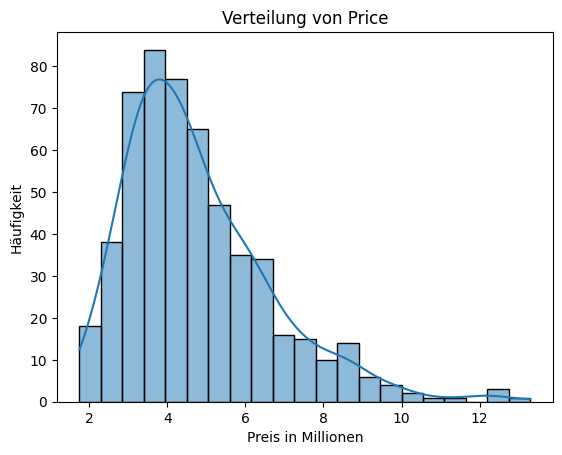

In [272]:
sns.histplot((data['price'] / 1e6), kde=True)
plt.title('Verteilung von Price')
plt.xlabel('Preis in Millionen')
plt.ylabel('Häufigkeit')
plt.show()

Schauen wir uns die Verteilung von Price in einem Balkendiagramm an, so lässt sich erkennen, dass die Verteilung rechtschief ist. 
Wir haben deutlich mehr Häuser im Datensatz die zwischen 2 und 8 Millionen kosten, als Häuser die mehr als 8 Millionen kosten.

Im nächsten Schritt erstellen wir eine "Correlation Heatmap", um herauszufinden welche Attribute den Haus Preis am meisten beeinflussen.  
Der Wertebereich liegt dabei zwischen -1 und 1, wobei 1 für eine stark positive Korrelation, -1 für eine stark negative Korrelation und 0 für keine Korrelation spricht. (Korrelation = Zusammenhang)

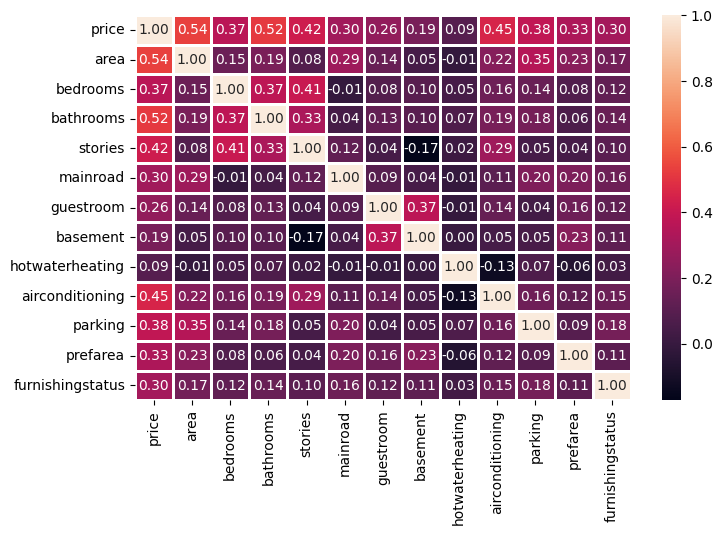

In [273]:
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, fmt=".2f", linewidths=1, cbar=True)
plt.show()

Man erkennt, dass die area und die Anzahl der Badezimmer den Preis am meisten beeinflussen, da dort die Korrelation im Vergleich zu den anderen Werten am höchsten liegt.

In [274]:
data = data.drop(columns=['hotwaterheating'])

In [275]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

y = scaler.fit_transform(y.values.reshape(-1, 1))

Teilen der Daten in Trainings- und Testdatensatz:

In [276]:
X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

st = StandardScaler()  
X_train = st.fit_transform(X_train)  
X_test= st.transform(X_test)

## 2. Modelling

In [277]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    R2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, R2
results = {}

for name, model in models.items():
    mae, mse, rmse, R2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 Score': R2}
for model, metrics in results.items():
    print(f"Model: {model}")
    
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

Model: Linear Regression
  MAE: 1004900.6036570418
  MSE: 1837081983752.633
  RMSE: 1355389.9747868262
  R2 Score: 0.636550311062412
Model: Random Forest
  MAE: 1030752.2327217124
  MSE: 1980211560100.7385
  RMSE: 1407199.9005474448
  R2 Score: 0.6082334474376188
Model: Gradient Boosting
  MAE: 972305.9158316762
  MSE: 1752698088059.0461
  RMSE: 1323895.044200652
  R2 Score: 0.6532448848007746
